Try gradient-descent training of MPS model on a GHZ state (single basis)

In [1]:
import numpy as np
import torch
from models import MPS, ComplexTensor
import matplotlib.pyplot as plt
from tools import generate_binary_space

In [2]:
#helper function to build unitaries from angles
from qtools import pauli_exp

In [33]:
#system size
L=4
#dimensionality of local hilbert space (2 =qubit)
local_dim =2
#bond dimension of the MPS
bond_dim = 10

Creates uniform, closed-boundary-conditions MPS pure state

In [34]:
psi =MPS(L=L, local_dim=local_dim, bond_dim=bond_dim)

Load datasets from numpy pickles

In [35]:
samples_fname = "datasets/samples_ghz_plus_z_basis_only_L=4_Nmeasure=100000.npy"
samples = np.load(samples_fname)


In [36]:
samples_tr = torch.tensor((samples + 1)/2).to(torch.long)

In [37]:
from torch.utils.data import TensorDataset, DataLoader

In [38]:
batch_size = 128
epochs = 2

In [39]:
ds = TensorDataset(samples_tr)

In [40]:
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [41]:
lr = .001
optim = torch.optim.Adam(lr=lr,params=psi.parameters())

In [42]:
losses = []
p10 = []


For my curiosity -- record probability assigned to a few basis states during training

In [43]:
x10 = torch.tensor([1,0,1,0], dtype=torch.long)


Train the MPS by minimizing negative-log-likelihood of the observed data.

In [44]:
for n in range(epochs):
    for i, samples in enumerate(dl):
        samples=samples[0]
        psi.zero_grad()
        loss = psi.nll_loss(samples)
        loss.backward()
        optim.step()
        if i%100==0:
            with torch.no_grad():
                losses.append(loss.item())
                p10.append(psi.prob_normalized(x10).item())
    print("finished epoch %d" %n)

finished epoch 0
finished epoch 1


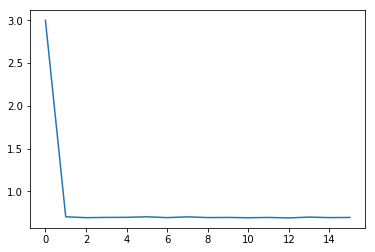

In [45]:
%matplotlib inline
plt.plot(losses)

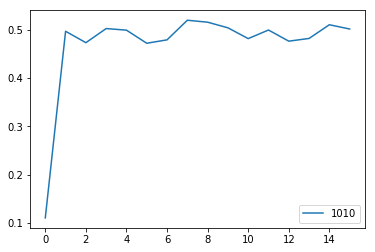

In [46]:
plt.plot(p10, label="1010")
plt.legend()

Look at the probability the trained state assigns to each z-basis state

In [47]:
basis = torch.tensor(generate_binary_space(L),dtype=torch.long)

In [52]:
with torch.no_grad():
    n = psi.norm().sqrt().item()
    for i in range(len(basis)):
        a = psi.amplitude(basis[i])
        print("{0} has amplitude {1:.4f} + i {2:.4f}".format(basis[i], a.real.item()/n, a.imag.item()/n))

tensor([1, 1, 1, 1]) has amplitude -0.0017 + i -0.0008
tensor([1, 1, 1, 0]) has amplitude 0.0048 + i -0.0019
tensor([1, 1, 0, 1]) has amplitude -0.0023 + i 0.0011
tensor([1, 1, 0, 0]) has amplitude 0.0012 + i 0.0020
tensor([1, 0, 1, 1]) has amplitude 0.0032 + i 0.0020
tensor([1, 0, 1, 0]) has amplitude 0.2472 + i -0.6467
tensor([1, 0, 0, 1]) has amplitude -0.0016 + i 0.0019
tensor([1, 0, 0, 0]) has amplitude -0.0022 + i 0.0009
tensor([0, 1, 1, 1]) has amplitude -0.0005 + i 0.0010
tensor([0, 1, 1, 0]) has amplitude -0.0006 + i -0.0000
tensor([0, 1, 0, 1]) has amplitude -0.6338 + i 0.3448
tensor([0, 1, 0, 0]) has amplitude 0.0002 + i 0.0012
tensor([0, 0, 1, 1]) has amplitude 0.0008 + i 0.0005
tensor([0, 0, 1, 0]) has amplitude -0.0012 + i 0.0012
tensor([0, 0, 0, 1]) has amplitude 0.0016 + i 0.0003
tensor([0, 0, 0, 0]) has amplitude -0.0008 + i -0.0005


In [49]:
from qtools import pauli_exp

In [50]:
theta = torch.tensor([[np.pi/2]*L])
phi = torch.zeros_like(theta)
U = pauli_exp(theta, phi)

with torch.no_grad():
    for i in range(len(basis)):
        print("{0} has probability {1:.4f}".format(basis[i], psi.prob_normalized(basis[i],rotation=U).item()))

tensor([1, 1, 1, 1]) has probability 0.0154
tensor([1, 1, 1, 0]) has probability 0.1099
tensor([1, 1, 0, 1]) has probability 0.1092
tensor([1, 1, 0, 0]) has probability 0.0150
tensor([1, 0, 1, 1]) has probability 0.1103
tensor([1, 0, 1, 0]) has probability 0.0147
tensor([1, 0, 0, 1]) has probability 0.0147
tensor([1, 0, 0, 0]) has probability 0.1100
tensor([0, 1, 1, 1]) has probability 0.1088
tensor([0, 1, 1, 0]) has probability 0.0146
tensor([0, 1, 0, 1]) has probability 0.0161
tensor([0, 1, 0, 0]) has probability 0.1093
tensor([0, 0, 1, 1]) has probability 0.0151
tensor([0, 0, 1, 0]) has probability 0.1115
tensor([0, 0, 0, 1]) has probability 0.1105
tensor([0, 0, 0, 0]) has probability 0.0147
